In [16]:
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [17]:
'''data columns are: Index(['Day', 'Month', 'Year', 'States/UTs', 'Rice', 'Wheat', 'Atta (Wheat)',
       'Gram Dal', 'Tur/Arhar Dal', 'Urad Dal', 'Moong Dal', 'Masoor Dal',
       'Sugar', 'Milk @', 'Groundnut Oil (Packed)', 'Mustard Oil (Packed)',
       'Vanaspati (Packed)', 'Soya Oil (Packed)', 'Sunflower Oil (Packed)',
       'Palm Oil (Packed)', 'Gur', 'Tea Loose', 'Salt Pack (Iodised)',
       'Potato', 'Onion', 'Tomato'],
      dtype='object')'''

"data columns are: Index(['Day', 'Month', 'Year', 'States/UTs', 'Rice', 'Wheat', 'Atta (Wheat)',\n       'Gram Dal', 'Tur/Arhar Dal', 'Urad Dal', 'Moong Dal', 'Masoor Dal',\n       'Sugar', 'Milk @', 'Groundnut Oil (Packed)', 'Mustard Oil (Packed)',\n       'Vanaspati (Packed)', 'Soya Oil (Packed)', 'Sunflower Oil (Packed)',\n       'Palm Oil (Packed)', 'Gur', 'Tea Loose', 'Salt Pack (Iodised)',\n       'Potato', 'Onion', 'Tomato'],\n      dtype='object')"

In [18]:
# Load the data from the CSV file
df = pd.read_csv(r"data\cleansing\filled\data_r_mean_filled.csv")

In [19]:
print(df.shape)

(89280, 26)


In [20]:
# df = df[df["Year"] >2023]
print(df.shape)

(8054, 26)


In [21]:
# Convert date columns to a datetime object
df['Date'] = pd.to_datetime(df[['Day', 'Month', 'Year']])
df.set_index('Date', inplace=True)

In [22]:
# Select the crops for prediction
crops = ["Rice", "Wheat", "Atta (Wheat)", "Gram Dal", "Tur/Arhar Dal", "Urad Dal", "Moong Dal", "Masoor Dal", "Sugar", "Milk @", "Groundnut Oil (Packed)", "Mustard Oil (Packed)", "Vanaspati (Packed)", "Soya Oil (Packed)", "Sunflower Oil (Packed)", "Palm Oil (Packed)", "Gur", "Tea Loose", "Salt Pack (Iodised)", "Potato", "Onion", "Tomato"]

In [8]:
# Create a dictionary to store the last known data for each state
last_known_data = {}
for state in df['States/UTs'].unique():
    last_known_data[state] = df[df['States/UTs'] == state].iloc[-1][crops].values

In [9]:
# Prepare data for LSTM
data = df[crops].values

In [10]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [11]:
# Split the data into training and testing sets
# note: take test from the end of the data
train_data, test_data = train_test_split(scaled_data, test_size=0.2)

In [12]:
# Create the function to create the dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

In [13]:
# Set look_back period (number of previous days to consider)
look_back = 7
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

In [14]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [ ]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(X_train.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)


In [ ]:
# Save the model
model.save('model.h5')

In [23]:
model.save('model.keras')

In [ ]:
# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

In [23]:
#load the model
#model = tensorflow.keras.models.load_model('model.h5')

In [24]:
# Make prediction for 6/9/2024
# First, prepare the input data for 6/9/2024 prediction
last_week_data = df[crops].iloc[-look_back:].values # Explanation: get the last 7 days data from the data frame
scaled_last_week = scaler.transform(last_week_data) # Explanation: scale the data 
reshaped_last_week = np.reshape(scaled_last_week, (1, look_back, len(crops))) # Explanation: reshape the data to fit the model input shape (1, 7, 23)


In [25]:
# Predict
prediction_scaled = model.predict(reshaped_last_week)
prediction = scaler.inverse_transform(prediction_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


In [26]:
# Create DataFrame for 6/9/2024 predictions
predictions_6_9_2024 = pd.DataFrame(data=prediction, columns=crops)

In [27]:
# Predict for all states using the last known data
for state, state_data in last_known_data.items():
    scaled_state_data = scaler.transform(state_data.reshape(1,-1))
    reshaped_state_data = np.reshape(scaled_state_data, (1, 1, len(crops)))

    state_prediction_scaled = model.predict(reshaped_state_data)
    state_prediction = scaler.inverse_transform(state_prediction_scaled)

    predictions_6_9_2024.loc[state] = state_prediction[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

In [28]:
# Display the predictions
print(predictions_6_9_2024)


                           Rice      Wheat  Atta (Wheat)    Gram Dal  \
0                     44.983723  35.046722     38.763771   85.597404   
Andaman and Nicobar   73.031204  51.891193     81.388428  101.442627   
Andhra Pradesh        62.360126  44.279732     63.447891   78.509552   
Assam                 63.516880  54.039776     47.480438  105.403450   
Bihar                 97.614868  78.157623     61.168163   87.344437   
Chandigarh            73.231529  59.039936     55.997101   96.008408   
Chhattisgarh          76.372108  64.156075     68.400108   93.879044   
Delhi                 81.525177  64.314140     66.398209   85.037560   
DNH and DD            68.020767  52.860775     52.168396   86.625305   
Goa                   53.948601  39.870525     52.665497   75.548317   
Gujarat               66.980927  57.349232     58.989891  102.494568   
Haryana               71.540642  60.490730     49.375618   95.400642   
Himachal Pradesh     103.324684  86.158386     58.706272   83.99

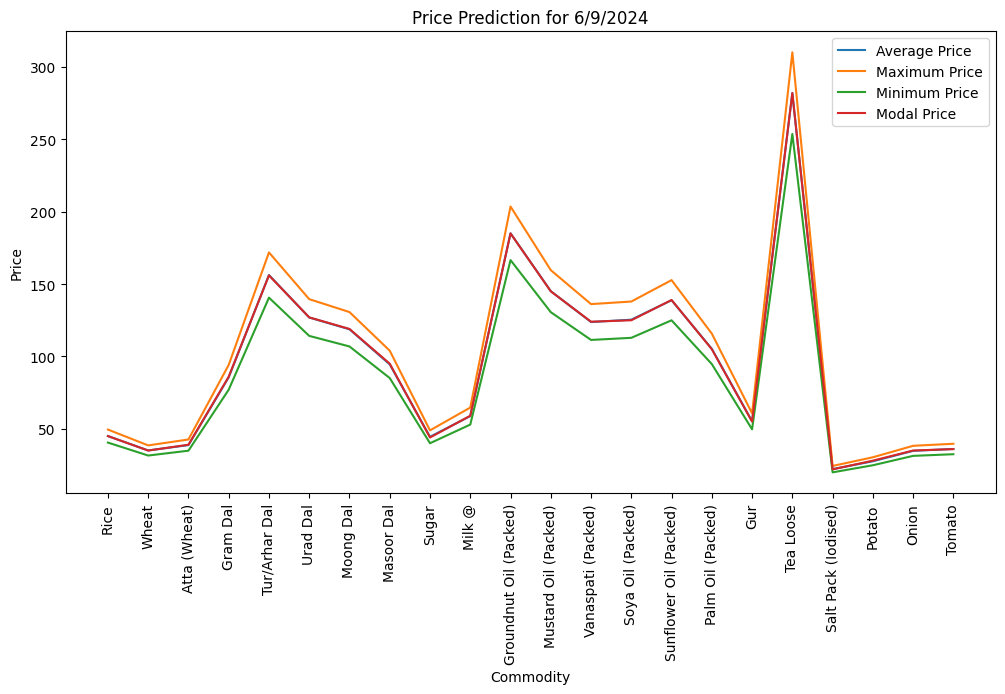

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 50)          │        14,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 22)             │         1,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,846 (280.65 KB)

 Trainable params: 35,922 (140.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,924 (140.33 KB)

In [15]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(predictions_6_9_2024.loc['Average Price'], label='Average Price')
plt.plot(predictions_6_9_2024.loc['Maximum Price'], label='Maximum Price')
plt.plot(predictions_6_9_2024.loc['Minimum Price'], label='Minimum Price')
plt.plot(predictions_6_9_2024.loc['Modal Price'], label='Modal Price')
plt.title('Price Prediction for 6/9/2024')
plt.xlabel('Commodity')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Display the model summary
model.summary()